In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic_2d


In [2]:
params={     
    'axes.labelsize'  : '14',   
    'axes.titlesize'  : '14',  
    'xtick.labelsize' :'14',
    'ytick.labelsize' :'14',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '10', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

## Read data

In [3]:
## IMERG
satellite_path = "/g/data/k10/cb4968/metrics/observations/IMERG/small_domain/pr_based/IMERG/pr_based_IMERG_3hrly_0-360_-30-30_3600x1800_2001-01_2023-12_boxsize_5/"
sat_files = sorted(glob(f"{satellite_path}pr_based_IMERG_3hrly_*.nc"))
ds_sat = xr.open_mfdataset(sat_files,chunks={"time":10})
# ERA5
ds_tcwv = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/tcwv/*.nc")))
ds_max_cape = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/max_cape/*.nc")))
ds_cape = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/cape/*.nc")))
## land sea mask
ds_lsm = xr.open_dataset("/g/data/k10/cr7888/era5_daily_means_5deg/lsm_5deg.nc") 

In [4]:
lsm = ds_lsm["lsm"]
# max precipitation
max_pr = ds_sat["pr_based_max_pr_30min"].resample(time='1D').max().where(lsm == 0)
# mean precipitation
mean_pr = ds_sat["pr_based_mean_pr"].resample(time='1D').mean().where(lsm == 0)
# Iorg
iorg= ds_sat["pr_based_Iorg"].resample(time='1D').mean().where(lsm == 0)
## make ERA5 data timestamps to match IMERG data
ds_tcwv["time"] = ds_tcwv["time"].dt.floor("D")
ds_max_cape["time"] = ds_max_cape["time"].dt.floor("D")
ds_cape["time"] = ds_cape["time"].dt.floor("D")

In [5]:
%%time
## IMERG daily to match ERA5 timestamps
mean_pr_match = mean_pr.sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()
iorg_match = iorg.sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()
max_pr_match = max_pr.sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()     

CPU times: user 1min 48s, sys: 14.8 s, total: 2min 3s
Wall time: 1min 43s


In [6]:
%%time
## ERA5 environmental conditions
tcwv = ds_tcwv["tcwv"].sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).where(lsm == 0).compute()
# max CAPE
max_cape = ds_max_cape["cape"].sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).where(lsm == 0).compute()
cape = ds_cape["cape"].sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).where(lsm == 0).compute()

CPU times: user 2.06 s, sys: 3.21 s, total: 5.27 s
Wall time: 5.22 s


## Figure 5

In [10]:
mean_pr_1D = mean_pr_match.values.flatten()
iorg_1D = iorg_match.values.flatten()
max_pr_1D = max_pr_match.values.flatten()

In [67]:
def compute_2d_hist(x, y, xmin=0.1, xmax=5, ymin=None, ymax=None, nbins=50, counts_thresh=10):
    '''
    Compute a 2D histogram of data density based on the input x and y
    '''
    
    if ymin==None and ymax==None:
        ymin, ymax = np.nanmin(y), np.nanmax(y)
    # 1) compute the raw 2D histogram
    counts, xedges, yedges = np.histogram2d(
        x, y,
        bins=nbins,
        range=[[xmin,xmax], [ymin, ymax]]
    )
    
    # 2) mask out bins with less than the threshold counts
    counts_masked = np.where(counts > counts_thresh, counts, np.nan)
    
    # 3) build the mesh to plot
    X, Y = np.meshgrid(xedges, yedges)
    return X, Y, counts_masked.T

In [69]:
X1, Y1, mean_max_hist = compute_2d_hist(mean_pr_1D, max_pr_1D, ymin=0.1, ymax=150, nbins=50, counts_thresh=10)
X2, Y2, mean_iorg_hist = compute_2d_hist(mean_pr_1D, iorg_1D, nbins=50, counts_thresh=10)

In [70]:
def compute_2d_hist_stat(x, y, z, xmin=0.1, xmax=5, ymin=None, ymax=None, nbins=50, counts_thresh=10):
    '''
    Compute a 2D histogram of data density based on the input x and y
    And get the stats of the 2D histogram based on z (environmental conditions in our case)
    '''
    if ymin==None and ymax==None:
        ymin, ymax = np.nanmin(y), np.nanmax(y)

    xbins, ybins = nbins, nbins
    xrange = [xmin, xmax]
    yrange = [ymin, ymax]

    ## mask out nans
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x2, y2, z2 = x[mask], y[mask], z[mask]
    
    stat, xedges, yedges, _ = binned_statistic_2d(
        x2,y2,z2,
        statistic='mean',
        bins=[xbins, ybins],
        range=[xrange, yrange]
    )
    
    counts, _, _, _ = binned_statistic_2d(
        x2, y2, None, statistic='count',
        bins=[xbins, ybins],
        range=[xrange, yrange]
    )
    
    ## mask out bins with less than the threshold counts
    stat[counts <= counts_thresh] = np.nan
    ## return transpose for plotting
    return {"x": xedges, "y": yedges, "stat": stat.T}
    

In [71]:
mean_max_iorg = compute_2d_hist_stat(mean_pr_1D, max_pr_1D, iorg_1D,ymin=0.1, ymax=150, nbins=50, counts_thresh=10)
mean_iorg_max = compute_2d_hist_stat(mean_pr_1D, iorg_1D, max_pr_1D, nbins=50, counts_thresh=10)

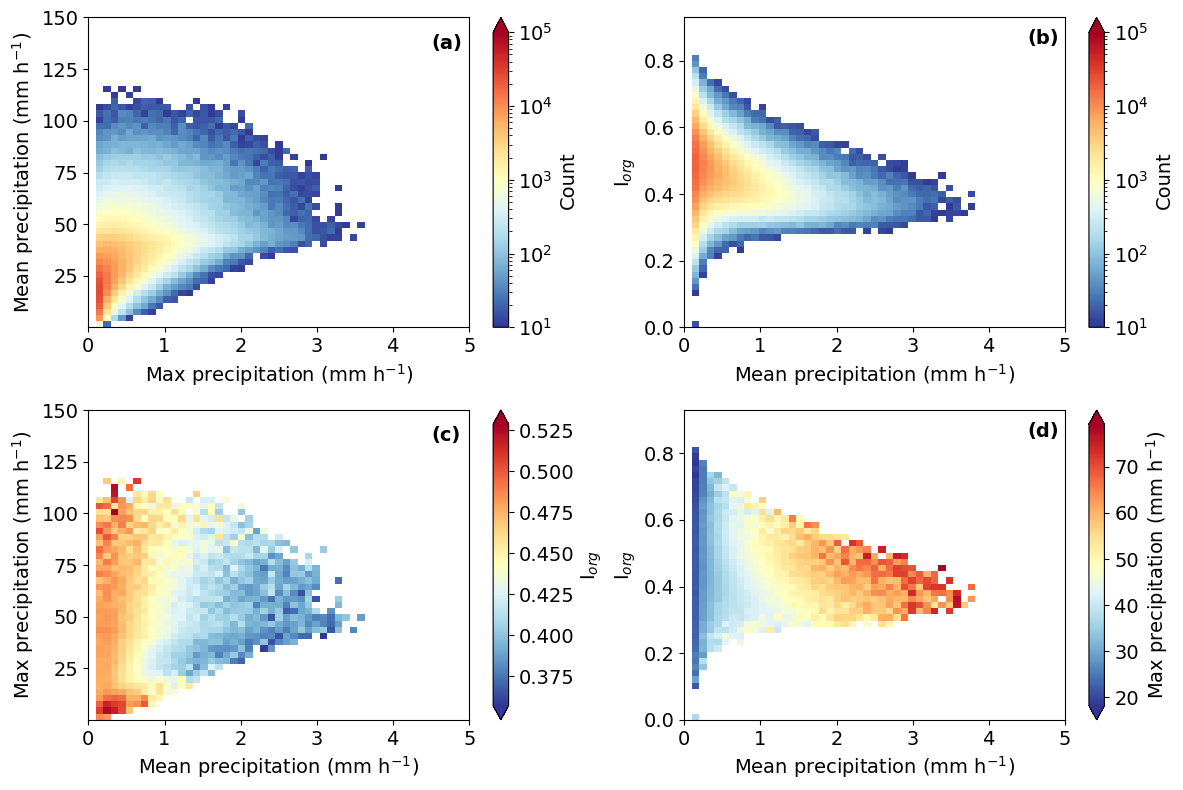

In [73]:
### Figure 5
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(221)
pcm1 = plt.pcolormesh(
    X1, Y1, mean_max_hist,       # note the transpose
    norm=LogNorm(vmin=10, vmax=10**5),
    cmap='RdYlBu_r',
    shading='auto'
)
plt.colorbar(pcm1, label="Count",extend ="max")
plt.xlabel("Max precipitation (mm h$^{-1}$)")
plt.ylabel("Mean precipitation (mm h$^{-1}$)")
ax1.set_xlim([0,5])
ax1.text(4.5,135, "(a)",fontsize=14, fontweight="bold") # x, y, s

ax2 = fig.add_subplot(222)
pcm2 = plt.pcolormesh(
    X2, Y2, mean_iorg_hist,       # note the transpose
    norm=LogNorm(vmin=10, vmax=10**5),
    cmap='RdYlBu_r',
    shading='auto'
)
plt.colorbar(pcm2, label="Count",extend ="max")
plt.xlabel("Mean precipitation (mm h$^{-1}$)")
plt.ylabel("I$_{org}$")
ax2.set_xlim([0,5])
ax2.text(4.5,0.85, "(b)",fontsize=14, fontweight="bold") # x, y, s


ax3 = fig.add_subplot(223)
pcm3 = ax3.pcolormesh(
    mean_max_iorg["x"], mean_max_iorg["y"], mean_max_iorg["stat"],
    cmap='RdYlBu_r', shading='auto',
)
cbar = plt.colorbar(pcm3, ax=ax3, label="I$_{org}$",extend="both")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax3.set_xlabel("Mean precipitation (mm h$^{-1}$)")
ax3.set_ylabel("Max precipitation (mm h$^{-1}$)")
ax3.set_xlim([0,5])
ax3.text(4.5,135, "(c)",fontsize=14, fontweight="bold") # x, y, s

ax4 = fig.add_subplot(224)
pcm4 = ax4.pcolormesh(
    mean_iorg_max["x"], mean_iorg_max["y"], mean_iorg_max["stat"],
    cmap='RdYlBu_r', shading='auto', 
)
cbar = plt.colorbar(pcm4, ax=ax4, label="Max precipitation (mm h$^{-1}$)",extend="both")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax4.set_xlabel("Mean precipitation (mm h$^{-1}$)")
ax4.set_ylabel("I$_{org}$")
ax4.set_xlim([0,5])

ax4.text(4.5,0.85, "(d)",fontsize=14, fontweight="bold") # x, y, s

plt.tight_layout()

plt.savefig("/home/565/dl6968/meso-org/Figures/Fig5.png", dpi=200, bbox_inches="tight")

plt.show()

## Figure 6

In [74]:
tcwv_1D = tcwv.values.flatten()
max_cape_1D =  max_cape.values.flatten()

In [75]:
## TCWV
mean_max_tcwv = compute_2d_hist_stat(mean_pr_1D, max_pr_1D, tcwv_1D, ymin=0.1, ymax=150, nbins=50, counts_thresh=10)
mean_iorg_tcwv = compute_2d_hist_stat(mean_pr_1D, iorg_1D, tcwv_1D, nbins=50, counts_thresh=10)
## max CAPE
mean_max_cape = compute_2d_hist_stat(mean_pr_1D, max_pr_1D, max_cape_1D, ymin=0.1, ymax=150, nbins=50, counts_thresh=10)
mean_iorg_cape = compute_2d_hist_stat(mean_pr_1D, iorg_1D, max_cape_1D, nbins=50, counts_thresh=10)

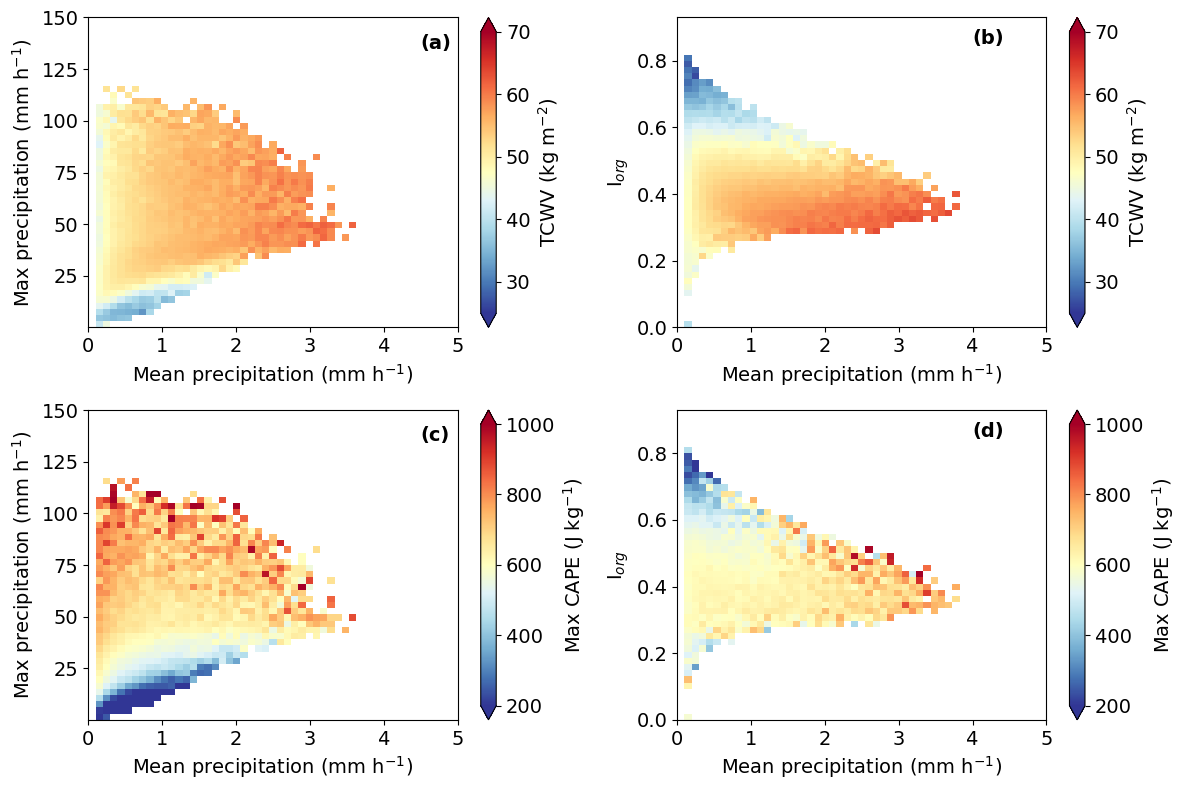

In [76]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(221)
pcm1 = ax1.pcolormesh(
    mean_max_tcwv["x"], mean_max_tcwv["y"], mean_max_tcwv["stat"],
    cmap='RdYlBu_r', shading='auto',vmin=25, vmax=70
)
cbar = plt.colorbar(pcm1, ax=ax1, label="TCWV (kg m$^{-2}$)",extend="both")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax1.set_xlabel("Mean precipitation (mm h$^{-1}$)")
ax1.set_ylabel("Max precipitation (mm h$^{-1}$)")
ax1.set_xlim([0,5])
ax1.text(4.5,135, "(a)",fontsize=14, fontweight="bold") # x, y, s

ax2 = fig.add_subplot(223)
pcm2 = ax2.pcolormesh(
    mean_max_cape["x"], mean_max_cape["y"], mean_max_cape["stat"],
    cmap='RdYlBu_r', shading='auto', vmin=200, vmax=1000
)
cbar = plt.colorbar(pcm2, ax=ax2, label="Max CAPE (J kg$^{-1}$)",extend="both")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax2.set_xlabel("Mean precipitation (mm h$^{-1}$)")
ax2.set_ylabel("Max precipitation (mm h$^{-1}$)")
ax2.set_xlim([0,5])
ax2.text(4.5,135, "(c)",fontsize=14, fontweight="bold") # x, y, s


ax3 = fig.add_subplot(222)
pcm3 = ax3.pcolormesh(
    mean_iorg_tcwv["x"], mean_iorg_tcwv["y"], mean_iorg_tcwv["stat"],
    cmap='RdYlBu_r', shading='auto', vmin=25, vmax=70
)
cbar = plt.colorbar(pcm3, ax=ax3, label="TCWV (kg m$^{-2}$)",extend="both")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax3.set_ylabel("I$_{org}$")
ax3.set_xlabel("Mean precipitation (mm h$^{-1}$)")
ax3.set_xlim([0,5])
ax3.text(4,0.85, "(b)",fontsize=14, fontweight="bold") # x, y, s

ax4 = fig.add_subplot(224)
pcm4 = ax4.pcolormesh(
    mean_iorg_cape["x"], mean_iorg_cape["y"], mean_iorg_cape["stat"],
    cmap='RdYlBu_r', shading='auto', vmin=200, vmax=1000
)
cbar = plt.colorbar(pcm4, ax=ax4, label="Max CAPE (J kg$^{-1}$)",extend="both")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax4.set_ylabel("I$_{org}$")
ax4.set_xlabel("Mean precipitation (mm h$^{-1}$)")
ax4.set_xlim([0,5])
ax4.text(4,0.85, "(d)",fontsize=14, fontweight="bold") # x, y, s

plt.tight_layout()

plt.savefig("/home/565/dl6968/meso-org/Figures/Fig6.png", dpi=200, bbox_inches="tight")
plt.show()